# Spectral Extraction
This notebook is a sandbox for the optimal spectral extraction routine.

In [61]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import lmfit

In [62]:
# Functions
def psf(scale, pix=76, xy=50, plot=False):
    """Make a psf of a given size and scale"""
    x, y = np.meshgrid(np.linspace(-1,1,pix), np.linspace(-1,1,pix))
    d = np.sqrt(xy*x*x+y*y)
    sigma, mu = 0.2, 0.0
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )*scale
    
    if plot:
        plt.imshow(g, interpolation='none', origin='lower')
        plt.show()
        
    return g

def make_frame(n_psfs, offset, pix, xy, plot=False, **scales):
    """Make a frame with N psfs with a pixel width and a pixel offset for each psf
    where each psf is scaled randomly"""
    # Set the values
    psf_locs = [38+offset*n for n in range(n_psfs)]
    
    # Make the frame
    frame = np.zeros((pix, pix+offset*n_psfs))
    for n, off in enumerate([i-38 for i in psf_locs]):
        frame[:, off:off+pix] += psf(scales['w{}'.format(n)], pix=pix)
    
    if plot:
        # Plot the frame
        plt.figure(figsize=(5, 5))
        plt.imshow(frame, interpolation='none', origin='lower')
        plt.show()

    return frame

def calc_spectrum(n_psfs, offset, pix, xy, plot=False, **scales):
    """Calculate a spectrum by column sum"""
    frame = make_frame(n_psfs, offset, pix, xy, **scales, plot=plot)
    spectrum = np.sum(frame, axis=0)
    
    return spectrum

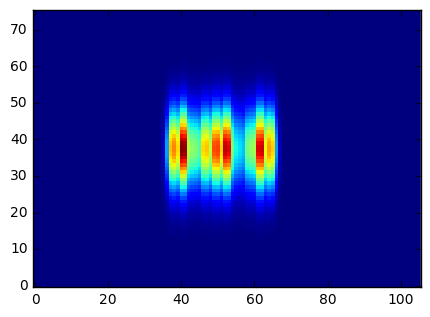

In [63]:
# Set the parameters
n_psfs = 10
offset = 3
pix = 76
xy = 30
loc = 1
scales = {'w{}'.format(n): v for n, v in enumerate(np.abs(np.random.normal(loc=loc, size=n_psfs, scale=loc/2)))}

# Make the frame
frame = make_frame(n_psfs=n_psfs, offset=offset, pix=pix, xy=xy, plot=True, **scales)

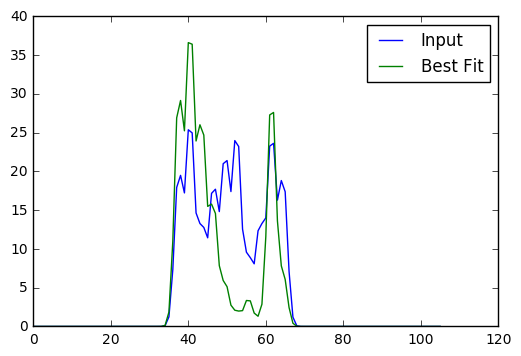

[[Model]]
    Model(make_frame)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 8056
    # variables        = 10
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = -inf
    Bayesian info crit = -inf
[[Variables]]
    w0:      1.05929987 +/- 0.00000000 (0.00%) (init = 1.0593)
    w1:      1.43170525 +/- 0.00000000 (0.00%) (init = 1.431705)
    w2:      0.68526013 +/- 0.00000000 (0.00%) (init = 0.6852601)
    w3:      0.96766030 +/- 0.00000000 (0.00%) (init = 0.9676603)
    w4:      1.17444384 +/- 0.00000000 (0.00%) (init = 1.174444)
    w5:      1.34157092 +/- 0.00000000 (0.00%) (init = 1.341571)
    w6:      0.47291875 +/- 0.00000000 (0.00%) (init = 0.4729188)
    w7:      0.69472254 +/- 0.00000000 (0.00%) (init = 0.6947225)
    w8:      1.32969539 +/- 0.00000000 (0.00%) (init = 1.329695)
    w9:      1.02667588 +/- 0.00000000 (0.00%) (init = 1.026676)
    offset:  3 (fixed)
    pix: 

In [69]:
def lmfitter(frame, model, uncertainty=None, method='leastsq', verbose=True, **kwargs):
    """Use lmfit to find the scale of each psf

    Parameters
    ----------
    data: sequence
        The frame data
    model: function
        The model to fit

    Returns
    -------
    lmfit.Model.fit.fit_report
        The results of the fit
    """
    # Initialize lmfit Params object
    initialParams = lmfit.Parameters()

    # Concatenate the lists of parameters
    param_list = [('w{}'.format(n), scales['w{}'.format(n)], True) for n in range(n_psfs)]
    param_list.append(('offset', offset, False))
    param_list.append(('pix', pix, False))
    param_list.append(('xy', xy, False))
    param_list.append(('n_psfs', n_psfs, False))

    # Set independent variables
    indep_vars = {}

    # Get values from input parameters.Parameters instances
    initialParams.add_many(*param_list)

    # Create the lightcurve model
    specmodel = lmfit.Model(model)
    specmodel.independent_vars = indep_vars.keys()

    # Set the uncertainty
    if uncertainty is None:
        uncertainty = np.ones_like(frame)

    # Fit model to the simulated data
    result = specmodel.fit(frame, weights=1/uncertainty, params=initialParams, method=method, **indep_vars, **kwargs)
    
    # Plot the original spectrum
    plt.figure()
    plt.plot(np.sum(frame, axis=0), label='Input')
    
    # And the fit spectrum
    fit = make_frame(**results.best_values)
    plt.plot(np.sum(fit, axis=0), label='Best Fit')
    plt.legend(loc=0)
    plt.show()
        
    # Return results
    return result

result = lmfitter(frame, make_frame, )
print(result.fit_report())